In [1]:
import cv2
from skimage.exposure import histogram
import numpy as np
import matplotlib.pyplot as plt
import math
import xlwt 
import xlrd
from xlwt import Workbook 
%matplotlib inline

In [2]:
# Take the path of the image and return the Image
def Read(Image):
    Image = "inputs/" + Image
    Original = cv2.imread(Image)
    if Original is not None:
        Copy = Original.copy()
        Copy = cv2.cvtColor(Copy, cv2.COLOR_BGR2GRAY)
        return [Original,Copy]
    else:
        return None

In [3]:
def show(Image):
    plt.imshow(Image , cmap = "gray")
    plt.rcParams["figure.figsize"] = (15,15)
    plt.show()

In [4]:
# Take an image and return the columns and rows of each circule
def GetCircules(Image , minR , maxR):
    Circles = cv2.HoughCircles(Image, cv2.HOUGH_GRADIENT, 1.2, 10 , param1=50 , param2=20 , minRadius=minR , maxRadius=maxR)
    CirclesCopy = np.copy(Circles)
    if Circles is not None:
        Columns = Circles[0][:,0]
        Columns.sort()
        Rows = Circles[0][:,1]
        Rows.sort()
        return [CirclesCopy , Columns , Rows]
    else:
        return None

In [5]:
# This function return Array of the questions ans answers
def NumOfChoicesAndQuestion(Columns , Rows):
    NumberOfChoices=0
    AverageOfChoices = []
    NumberOfQuestions=0
    AverageOfQuestions = []
    
    Count = 0
    Sum = 0
    for i in range(len(Columns)-1):
        if abs(Columns[i]-Columns[i+1]) < int((10+8)/2) :      # each circule must be far from the another by 3 
            Count = Count+1
            Sum = Sum+Columns[i]
        else:
            if Count > 2:                           # 3 Circules at least in one column
                AverageOfChoices.append(int(Sum/Count))
                NumberOfChoices = NumberOfChoices+1
            Sum = 0
            Count = 0
            
    if Count > 2:  
        AverageOfChoices.append(int(Sum/Count))
        NumberOfChoices = NumberOfChoices+1
    Sum = 0
    Count = 0
                
        
    for i in range(len(Rows)-1):
        if abs(Rows[i]-Rows[i+1]) < int((10+8)/2):            # each circule must be far from the another by 3
            Count = Count+1
            Sum = Sum+Rows[i]
        else:
            if Count > 2:                         # 3 Circules at least in one rows
                AverageOfQuestions.append(int(Sum/Count))
                NumberOfQuestions = NumberOfQuestions+1
            Sum = 0
            Count = 0
       
    if Count > 2:
        AverageOfQuestions.append(int(Sum/Count))
        NumberOfQuestions = NumberOfQuestions+1
    Sum = 0
    Count = 0
                
    return [NumberOfChoices , NumberOfQuestions , AverageOfChoices , AverageOfQuestions]

In [6]:
# This function take the column and the row of an answer and detect of which 
# question this answer belong and what is the answer (A,B,C,D,...)
def GetInformationOfAnswer(column, row , AverageOfChoices , AverageOfQuestions):
    Question = 0
    for i in range(len(AverageOfQuestions)):
        if abs(row - AverageOfQuestions[i]) < int((10+8)/2):
            Question = i+1
            break


    Answer = 0
    for i in range(len(AverageOfChoices)):
        if abs(column - AverageOfChoices[i]) < int((10+8)/2):
            Answer = i+1
            break
    return [Question , Answer]

In [7]:
#this function return only the row and the column of each answer
def GetOnlyAnswer(Image , minR , maxR):

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    
    img_erosion = cv2.morphologyEx(Image, cv2.MORPH_DILATE , kernel)
    img_erosion = cv2.morphologyEx(img_erosion, cv2.MORPH_DILATE , kernel)
    img_erosion = cv2.morphologyEx(img_erosion, cv2.MORPH_DILATE , kernel)

    img_erosion = cv2.morphologyEx(img_erosion, cv2.MORPH_ERODE , kernel)
    img_erosion = cv2.morphologyEx(img_erosion, cv2.MORPH_ERODE , kernel)
    img_erosion = cv2.morphologyEx(img_erosion, cv2.MORPH_ERODE , kernel)

    img_erosion = cv2.GaussianBlur(img_erosion,(5,5),cv2.BORDER_DEFAULT)
    img_erosion = cv2.GaussianBlur(img_erosion,(5,5),cv2.BORDER_DEFAULT)
    img_erosion = cv2.GaussianBlur(img_erosion,(5,5),cv2.BORDER_DEFAULT)
    
#     show(img_erosion)
    
    Circles = cv2.HoughCircles(img_erosion, cv2.HOUGH_GRADIENT, 1.2, 10 , param1=50 , param2=20 , minRadius=minR , maxRadius=maxR)
    return [Circles, img_erosion]

In [8]:
# This function read the file of model answer
def ReadModelAnswer(File):
    File = "modelanswers/"+File
    f= open(File,"r")
    CorrectAnswer =f.readlines()
    for i in range(len(CorrectAnswer)):
        CorrectAnswer[i] = CorrectAnswer[i].strip(); 
    return CorrectAnswer


In [9]:
def BoundAnswers(Answer , Image):
    plt.rcParams["figure.figsize"] = (16,16)
    if Answer is not None: 
        for i in Answer[0,:]:
            cv2.circle(Image, (i[0],i[1]), i[2], (0,255,0), 2) 
    plt.imshow(Image)
    plt.show()

In [10]:
def ModifyLetterAndNumMap(AllAnswer ,NumOfRows ,NumOfChoices , NumOfQuestions):
    Letters = {1:"A" , 2:"B",3:"C" , 4:"D",5:"E" , 6:"F"}
    if NumOfRows == 1:
        for i in range(len(AllAnswer)):
            AllAnswer[i][1] = Letters.get(AllAnswer[i][1])
            
    elif NumOfRows == 2:
        Segment = NumOfChoices/2
        for i in range(len(AllAnswer)):
            if AllAnswer[i][1] > Segment:
                AllAnswer[i][0] = AllAnswer[i][0]+NumOfQuestions
                AllAnswer[i][1] = int(AllAnswer[i][1] - Segment)
            AllAnswer[i][1] = Letters.get(AllAnswer[i][1])
            
    elif NumOfRows == 3:
        Segment = NumOfChoices/3
        for i in range(len(AllAnswer)):
            if AllAnswer[i][1] > 2*Segment:
                AllAnswer[i][0] = AllAnswer[i][0]+(2*NumOfQuestions)
                AllAnswer[i][1] = int(AllAnswer[i][1] - (2*Segment))
                
            elif AllAnswer[i][1] > Segment:
                AllAnswer[i][0] = AllAnswer[i][0]+(NumOfQuestions)
                AllAnswer[i][1] = int(AllAnswer[i][1] - (Segment))
                
            AllAnswer[i][1] = Letters.get(AllAnswer[i][1])
    return AllAnswer

In [11]:
def RemoveDoublecate(AllAnswer):
    for i in range(len(AllAnswer)):
        for j in range(len(AllAnswer)):
            if (i != j):
                if(AllAnswer[i][0] == AllAnswer[j][0]):
                    AllAnswer[i][1] = None
                    AllAnswer[j][1] = None
    return AllAnswer

In [12]:
def CalculateGrade(AllAnswer , CorrectAnswer):
    Grade = 0
    for i in range(len(AllAnswer)):
        if CorrectAnswer[AllAnswer[i][0]-1] == AllAnswer[i][1]:
            Grade = Grade+1
            
    return Grade

In [13]:
def QuestionAndItsAnswer(OnlyAnswer ,AverageOfChoices , AverageOfQuestions):
    AllAnswer = []
    for i in OnlyAnswer[0]:
        answer = GetInformationOfAnswer( i[0],i[1], AverageOfChoices , AverageOfQuestions)
        AllAnswer.append([answer[0] , answer[1]])
        
    return AllAnswer

In [14]:
def DetectRaduisAverage(Image , Original):
    AllCircles = GetOnlyAnswer(Image , 2 , 30)
    Circles = AllCircles[0]
#     Circles = cv2.HoughCircles(Image, cv2.HOUGH_GRADIENT, 1.2, 10 , param1=50 , param2=20 , minRadius=3 , maxRadius=12)
    if Circles is not None:
        Radius = Circles[0][:,2]
        SumRadius = Radius.sum()
        RadiusAverage = int(SumRadius/len(Radius))
#         BoundAnswers(Circles , Original)
        return [RadiusAverage,Circles]
    else:
        return None

In [15]:
def MaxFun(AllAnswer):
    ans = []
    for i in AllAnswer:
        ans.append(int(i[0]))

    return max(ans)

In [16]:
def Write(Grade = None , Name = None , Message = None):
    from openpyxl import load_workbook
    workbook = load_workbook(filename="output/Sheet.xlsx")
    sheet = workbook.active
    sheet.append([Name , Grade , Message])
    workbook.save(filename="output/Sheet.xlsx")

In [18]:
# The main
def BubbleSheet(Exam , Model):
# Read the image (Original and copy)
    ReadImage = Read(Exam)
    if ReadImage is not None:
        Original = ReadImage[0]
        ForInitialAnswer = Original.copy()
        ForAllCircles = Original.copy()
        ForOnlyAnswer = Original.copy()
        Copy = ReadImage[1]

        # AverageRadius
        Initial = DetectRaduisAverage(Copy,ForInitialAnswer) ## Print the resulf of dilation and erosion and bound the answer 
        if Initial is not None:
            AverageRadius = Initial[0]
            ###
            InitialCircles = Initial[1]
        #     print(AverageRadius)                             ## Print the average radius
        else:
            Grade = 0
            Message = "No answer"
            print(Message)
            Write(None , None , Message)

        # TestDetection(Original,InitialCircles)
        ###
        if Initial is not None:
            # get the columns and rows for all circules
            Circles = GetCircules(Copy , AverageRadius-1 , AverageRadius+1)
            if Circles is not None:
                AllCircules = Circles[0]
                Columns = Circles[1]
                Rows = Circles[2]

        #         ####
        #         TestDetection(ForAllCircles , AllCircules)
        #         ####
                # get num of choices and question and the average of questions and answers
                NumOfChoices = NumOfChoicesAndQuestion(Columns , Rows)[0]
                NumOfQuestions = NumOfChoicesAndQuestion(Columns , Rows)[1]
                AverageOfChoices = NumOfChoicesAndQuestion(Columns , Rows)[2]
                AverageOfQuestions = NumOfChoicesAndQuestion(Columns , Rows)[3]



                # get only answers and draw them
                OnlyAnswer = GetOnlyAnswer(Copy,AverageRadius-1 , AverageRadius+1)[0]
                ImageAfterErosion = GetOnlyAnswer(Copy,AverageRadius-1 , AverageRadius+1)[1]

                # Read model answer
                CorrectAnswer = ReadModelAnswer(Model)

                if OnlyAnswer is not None:
                    # draw only answer
                    BoundAnswers(OnlyAnswer , ForOnlyAnswer)

                    # get the number of question and its answer
                    AllAnswer = QuestionAndItsAnswer(OnlyAnswer , AverageOfChoices,AverageOfQuestions)

                    # Modify the number of question and its answer
                    NumOfRows = math.ceil(len(CorrectAnswer)/NumOfQuestions)
            #         print(NumOfRows)                                            ## Print number of rows
                    AllAnswer = ModifyLetterAndNumMap(AllAnswer ,NumOfRows, NumOfChoices , NumOfQuestions)
                    AllAnswer = RemoveDoublecate(AllAnswer)
                    if MaxFun(AllAnswer) > len(CorrectAnswer):
                        Message = "Error in the system , error (0)"
                        Grade = -1
                    else:
                        # Calculate the grade
                        Grade = CalculateGrade(AllAnswer , CorrectAnswer)
                else:
                    Grade = -1
                    Message = "Error in the system , error (1)"
                    print(Message)

            else:
                Message = "Error in the system , error (2)"
                Grade = -1
                print(Message)



            # print The grade
            if Grade == -1:
                print(Message)
                Write(Grade , None , Message)

            elif Grade == 0:
                print("Num of correct answers = 0")
                print("Percentage = 0%")
                Write(Grade , None , None)
            else:
                percentage = (Grade/len(CorrectAnswer) * 100)
                percentage = (math.floor(percentage/.1))/10
                print("Num of correct answers = " + str(Grade))
                print("Percentage = " + str(percentage) + "%")
                Write(Grade , None , None)
    else:
        Message = "Can't load image"
        print(Message)
        Write(None , None , Message)

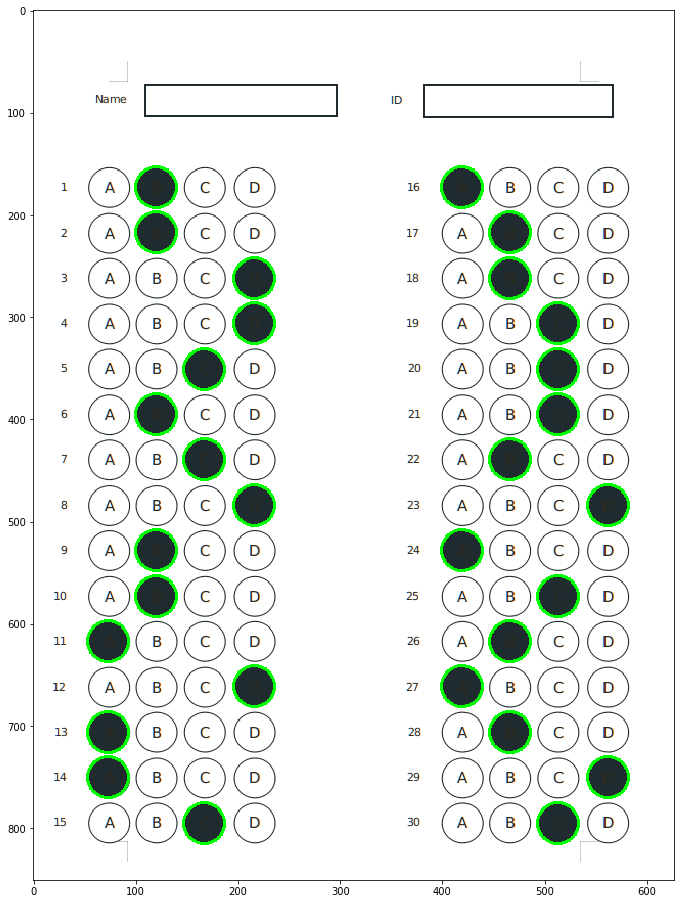

Num of correct answers = 13
Percentage = 43.3%


In [21]:
BubbleSheet("Four0.png" , "Four0.txt")

# Bubble sheet correction
Help you to correct a bubble sheet, just take <ins>a model answer and an image of bubble sheet to be corrected</ins>
and give you the result

## Prerequisites 
* python3
* jupyter notebook

## Getting started 
* Clone the repo 
* Put the bubble sheet image in the directory <ins>inputs</ins>
* Put the model answer in the directory <ins>modelanswers</ins>
* Running the code 
    * Pass the name of bubble sheet image as the first parameter to <ins>BubbleSheet()</ins> function
    * Pass the name of the model answer as the second parameter to <ins>BubbleSheet()</ins>
        * Example: 
        ![BubbleSheet() function](https://github.com/sofyanmahmoud0000/BubbleSheetCorrector/blob/master/BubbleSheet.png)
* Get the result and Enjoy !!!

## Inputs & Model answers 
* Inputs 
    * Example:
    ![Bubble sheet to be corrected](https://github.com/sofyanmahmoud0000/BubbleSheetCorrector/blob/master/Input.png)
    
* Model answer 
    * Example:
    ![Model answer](https://github.com/sofyanmahmoud0000/BubbleSheetCorrector/blob/master/ModelAnswer.png)
    
## Output
* Example:
![Output](https://github.com/sofyanmahmoud0000/BubbleSheetCorrector/blob/master/Output.png)

## Build with 
* [python 3]() - Language used
* [jupyter notebook](https://jupyter.org/) - 

## Development and support 
If you have any questions on how to use this stemmer, or have ideas for future development, please send me an e-mail to sofyan1020@gmail.com.

## Authors 
[Sofyan Mahmoud](https://github.com/sofyanmahmoud0000) - Computer engneering

## Licence 
MIT